Hello from fashion-mnist!
data/fashionmnist/t10k-images-idx3-ubyte
data/fashionmnist/fashion-mnist_test.csv
data/fashionmnist/t10k-labels-idx1-ubyte
data/fashionmnist/train-images-idx3-ubyte
data/fashionmnist/fashion-mnist_train.csv
data/fashionmnist/train-labels-idx1-ubyte
Using device: cpu
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...  

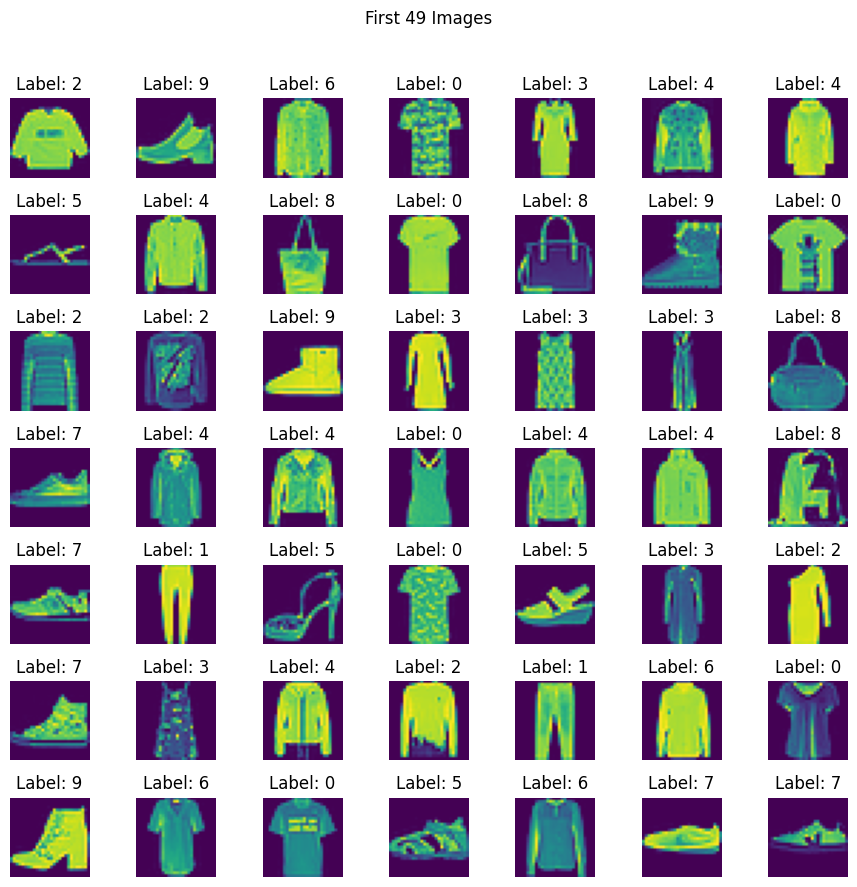

In [38]:
import numpy as np
import pandas as pd
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def check_data():
    for dirname, _, filenames in os.walk('data'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


def check_gpu():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")


def main():
    print("Hello from fashion-mnist!")
    check_data()

    torch.manual_seed(42)
    check_gpu()

    df = pd.read_csv('data/fashionmnist/fashion-mnist_train.csv')
    print(df.head())
    print('The shape of dataframe: ', df.shape)

    # Create a 7x7 grid of images
    fig, axes = plt.subplots(7, 7, figsize=(9, 9))
    fig.suptitle("First 49 Images", fontsize=12)

    print('axes: ', axes)
    print(axes[0][0])

    # Plot the first 49 images from the dataset
    for i, ax in enumerate(axes.flat):
        img = df.iloc[i, 1:].values.reshape(28, 28)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {df.iloc[i, 0]}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()


if __name__ == "__main__":
    main()
